<a href="https://colab.research.google.com/github/Loga19818eeanvesh/TensorFlow_DeepLearning_Assignments/blob/main/c1w4_a1_VGG_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 3.7 kB/s 
     |████████████████████████████████| 454 kB 38.6 MB/s 
     |████████████████████████████████| 3.0 MB 39.3 MB/s 
     |████████████████████████████████| 2.9 MB 41.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalli

In [6]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten,  Activation , Conv2D , BatchNormalization , Add , MaxPool2D , GlobalAveragePooling2D , Dense
import tensorflow_datasets as tfds
print("Version of tensorflow is : ",tf.__version__)
from tensorflow.python.keras.utils.vis_utils import plot_model

Version of tensorflow is :  2.2.0


In [41]:
class sub_model(Model):
  def __init__(self,filters,noof_layers):
    super(sub_model , self ).__init__(name  ='')
    self.noof_layers = noof_layers
    self.filters = filters
    self.conv2d = Conv2D(filters , 3 , activation='relu')
    self.pool  = MaxPool2D((2,2))

  def call(self,inputs):
    x = self.conv2d(inputs)
    for i in range(1,self.noof_layers):
      x = Conv2D(self.filters , 3 , activation='relu')(x)
    x = self.pool(x)
    return x

In [42]:
class VGG_Net(Model):
  def __init__(self,num_classes , activation = 'softmax'):
    super(VGG_Net, self).__init__(name="")
    self.block1 = sub_model(filters=64,noof_layers=2)
    self.block2 = sub_model(filters=128,noof_layers=2)
    self.block3 = sub_model(filters=256,noof_layers=3)
    self.block4 = sub_model(filters=512,noof_layers=3)
    self.block5 = sub_model(filters=512,noof_layers=3)
    self.flatten = Flatten()
    self.dense1 = Dense(units=4096,activation='relu')
    self.dense2 = Dense(units=4096,activation='relu')
    self.classifier =  Dense(num_classes , activation = tf.keras.activations.get(activation))

  def call(self,inputs):
    x = self.block1(inputs)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.classifier(x)
    return x

In [48]:
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        conv2d_layers = {}
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(self.repetitions):
            
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            conv2d_layers[f'conv2D_{i}'] = tf.keras.layers.Conv2D(self.filters, self.kernel_size,
                                                               activation= 'relu', padding= 'same')
        self.conv2d_layers = conv2d_layers
        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size, strides=strides)
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        x = self.conv2d_layers['conv2D_0'](inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            x = self.conv2d_layers[f'conv2D_{i}'](x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)
      
        return max_pool


In [49]:
class MyVGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(MyVGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(filters=64, kernel_size=3, repetitions=2)
        self.block_b = Block(filters=128, kernel_size=3, repetitions=2)
        self.block_c = Block(filters=256, kernel_size=3, repetitions=3)
        self.block_d = Block(filters=512, kernel_size=3, repetitions=3)
        self.block_e = Block(filters=512, kernel_size=3, repetitions=3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(256, activation='relu')
        # Finally add the softmax classifier using a Dense layer
        self.classifier =tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.classifier(x)
        return x

In [50]:
vggnet_model = MyVGG(num_classes=2)

In [51]:
vggnet_model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy' , metrics=['acc'])

In [45]:
dataset = tfds.load('cats_vs_dogs', split=tfds.Split.TRAIN, data_dir='data/')

In [46]:
def preprocess(features):
    # Resize and normalize
    image = tf.image.resize(features['image'], (224, 224))
    return tf.cast(image, tf.float32) / 255., features['label']

# Apply transformations to dataset
dataset = dataset.map(preprocess).batch(32)


In [ ]:

history = vggnet_model.fit(dataset, epochs=1)

In [53]:
vggnet_model.summary()

Model: "my_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block (Block)                multiple                  38720     
_________________________________________________________________
block_1 (Block)              multiple                  221440    
_________________________________________________________________
block_2 (Block)              multiple                  1475328   
_________________________________________________________________
block_3 (Block)              multiple                  5899776   
_________________________________________________________________
block_4 (Block)              multiple                  7079424   
_________________________________________________________________
flatten_8 (Flatten)          multiple                  0         
_________________________________________________________________
dense_24 (Dense)             multiple                  64227

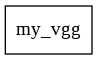

In [54]:
plot_model(vggnet_model , to_file = "vggnet.png" , show_shapes = True , show_layer_names = True)